# Exploratory Data Analysis

In [217]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## Imports

In [218]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import datetime
import xlrd
from tabulate import tabulate
import seaborn as sns

In [219]:
data_folder = Path("data") 
all_csv = list(data_folder.glob("*.csv"))

---

## Preprocessing

In [220]:
def icmp_dateformat_to_datetime(icmp_time_mark):
    """
    Convert ICMP time mark to datetime format
    
    Args:
        icmp_time_mark (float): ICMP time mark
    
    Returns:
        datetime_date (datetime): Datetime format of ICMP time mark
    """
    datetime_date = xlrd.xldate_as_datetime(icmp_time_mark, 0)
    datetime_date = datetime_date + datetime.timedelta(hours=1)
    return datetime_date

In [221]:

def time_encoder(df):
  """
  Encode time features from datetime column
  
  Args:
      df (DataFrame): Dataframe to encode time features
      
  Returns:
      df (DataFrame): Dataframe with encoded time features
  """
  df['time'] = pd.to_datetime(df['DateTime'])
  df['hour'] = df['time'].dt.hour
  df['day'] = df['time'].dt.day
  return df

In [222]:
data_frames = {}
for file in tqdm(all_csv):
  df = pd.read_csv(file, sep=";", decimal=",")
  df['DateTime'] = df['DateTime'].apply(icmp_dateformat_to_datetime)
  df = time_encoder(df)  
  df.set_index('DateTime', inplace=True)
  data_frames[file.stem] = df

100%|██████████| 3/3 [00:00<00:00, 11.60it/s]


---

## Data Understanding

In [223]:
for key, df in data_frames.items():
    print(f"DataFrame: {key}")
    print(tabulate(df.describe(), headers='keys', tablefmt='pretty'))
    print("\n")  # Adds a newline for better separation between tables

DataFrame: PAC07
+-------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+---------------------+-----+-------------------------------+--------------------+--------------------+
|       |        ABP         |   ABP_BaroIndex    | ABP_HRVstats_RMSSD | ABP_HRVstats_SDSD  |   ABP_HRVpsd_LF   |   ABP_HRVpsd_HF    | ABP_HRVpsd_LF_to_HF  |   ABP_HRVpsd_TP   |    ABP_FundAmp     |         HR         |        ICP         |        TEMP        |       ETCO2        | cpp |         Prx         | AMP |             time              |        hour        |        day         |
+-------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------------+-------------------+--------------------+---

### Rejection of AMP CPP and TEMP values

The cpp temp and amp values lack variability, rendering them unsuitable for our model. As such, they will not contribute to improving the model's accuracy or ensuring its stationarity, and can be excluded from our analysis.

In [224]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.drop(columns=['TEMP', 'cpp', 'AMP'])

100%|██████████| 3/3 [00:00<00:00, 1002.78it/s]


### Correlation

In [291]:
def corr_melt(corr):
    """
    Melt correlation matrix to be used to compare correlation between patients
    
    Args:
        df (DataFrame): Dataframe to melt
        
    Returns:
        df_melt (DataFrame): Melted dataframe
    """
    abp_corr = corr['ABP'].reset_index()    
    corr_melted = abp_corr.melt(id_vars = ['ABP'])
    corr_melted['patient'] = key
    return corr_melted

  0%|          | 0/3 [00:00<?, ?it/s]

                  index       ABP
0                   ABP  1.000000
1         ABP_BaroIndex -0.095517
2    ABP_HRVstats_RMSSD  0.140027
3     ABP_HRVstats_SDSD  0.140205
4         ABP_HRVpsd_LF -0.128820
5         ABP_HRVpsd_HF -0.140405
6   ABP_HRVpsd_LF_to_HF -0.117959
7         ABP_HRVpsd_TP -0.158996
8           ABP_FundAmp  0.520742
9                    HR -0.411442
10                  ICP -0.316388
11                ETCO2 -0.538322
12                  Prx -0.044335
13                 time -0.396225
14                 hour  0.019332
15                  day -0.395104


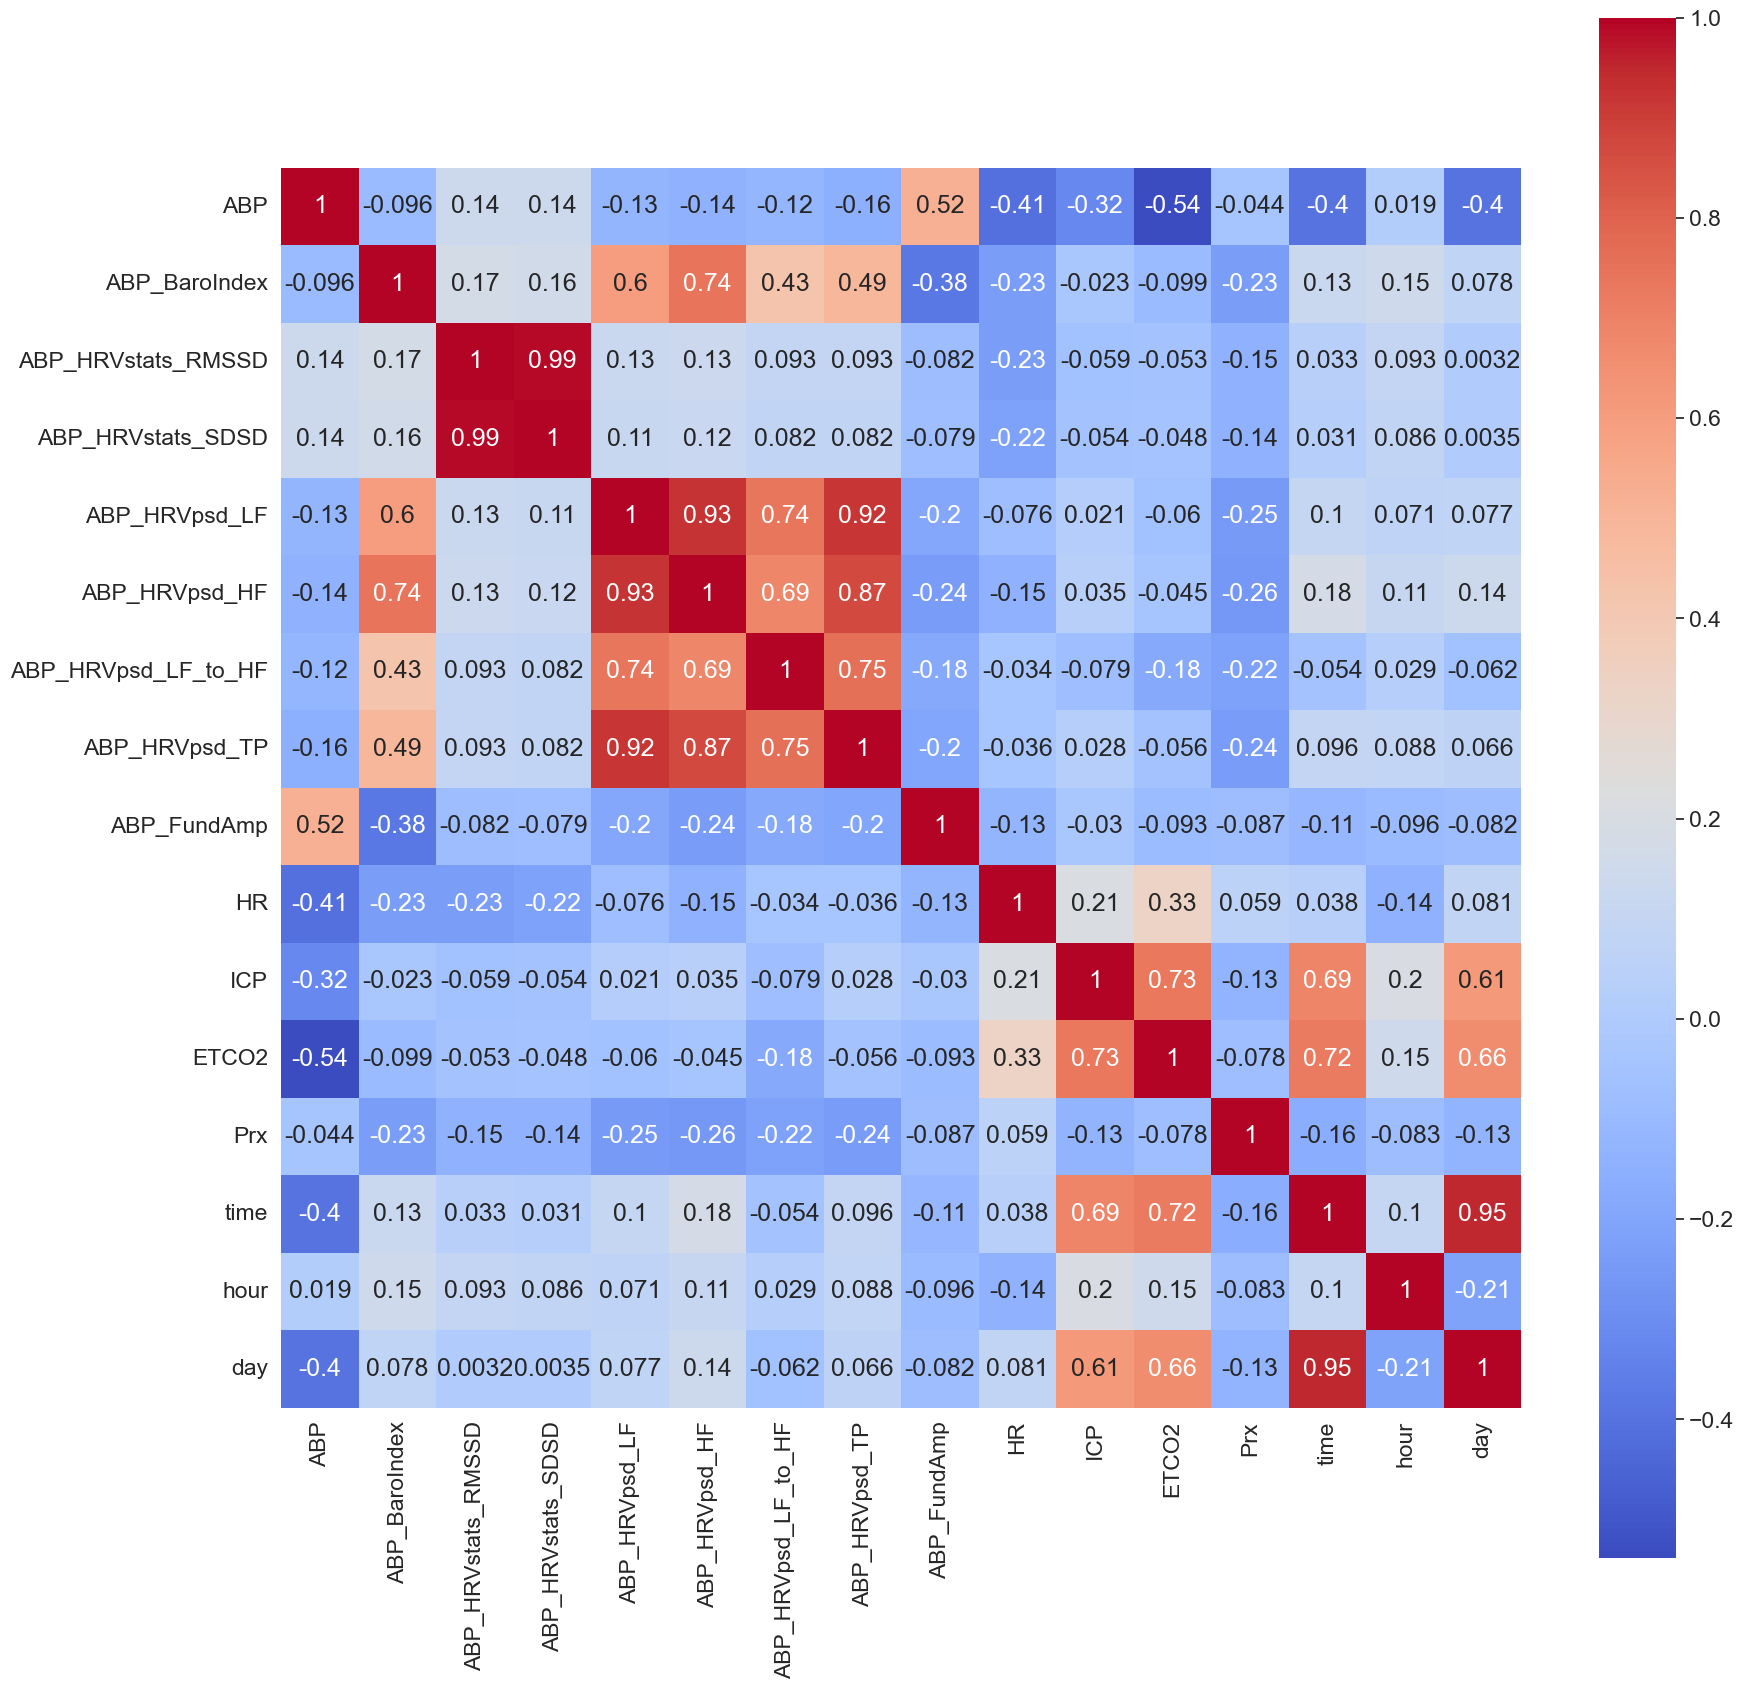

 33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]

                  index       ABP
0                   ABP  1.000000
1         ABP_BaroIndex  0.260555
2    ABP_HRVstats_RMSSD  0.148814
3     ABP_HRVstats_SDSD  0.143795
4         ABP_HRVpsd_LF  0.465625
5         ABP_HRVpsd_HF  0.377401
6   ABP_HRVpsd_LF_to_HF  0.476556
7         ABP_HRVpsd_TP  0.445518
8           ABP_FundAmp  0.595305
9                    HR  0.060499
10                  ICP  0.110108
11             STO2LEFT -0.339518
12            STO2RIGHT -0.308579
13                ETCO2 -0.611347
14                  CO2 -0.604128
15                  Prx  0.104161
16                 time  0.511492
17                 hour -0.100741
18                  day -0.628315


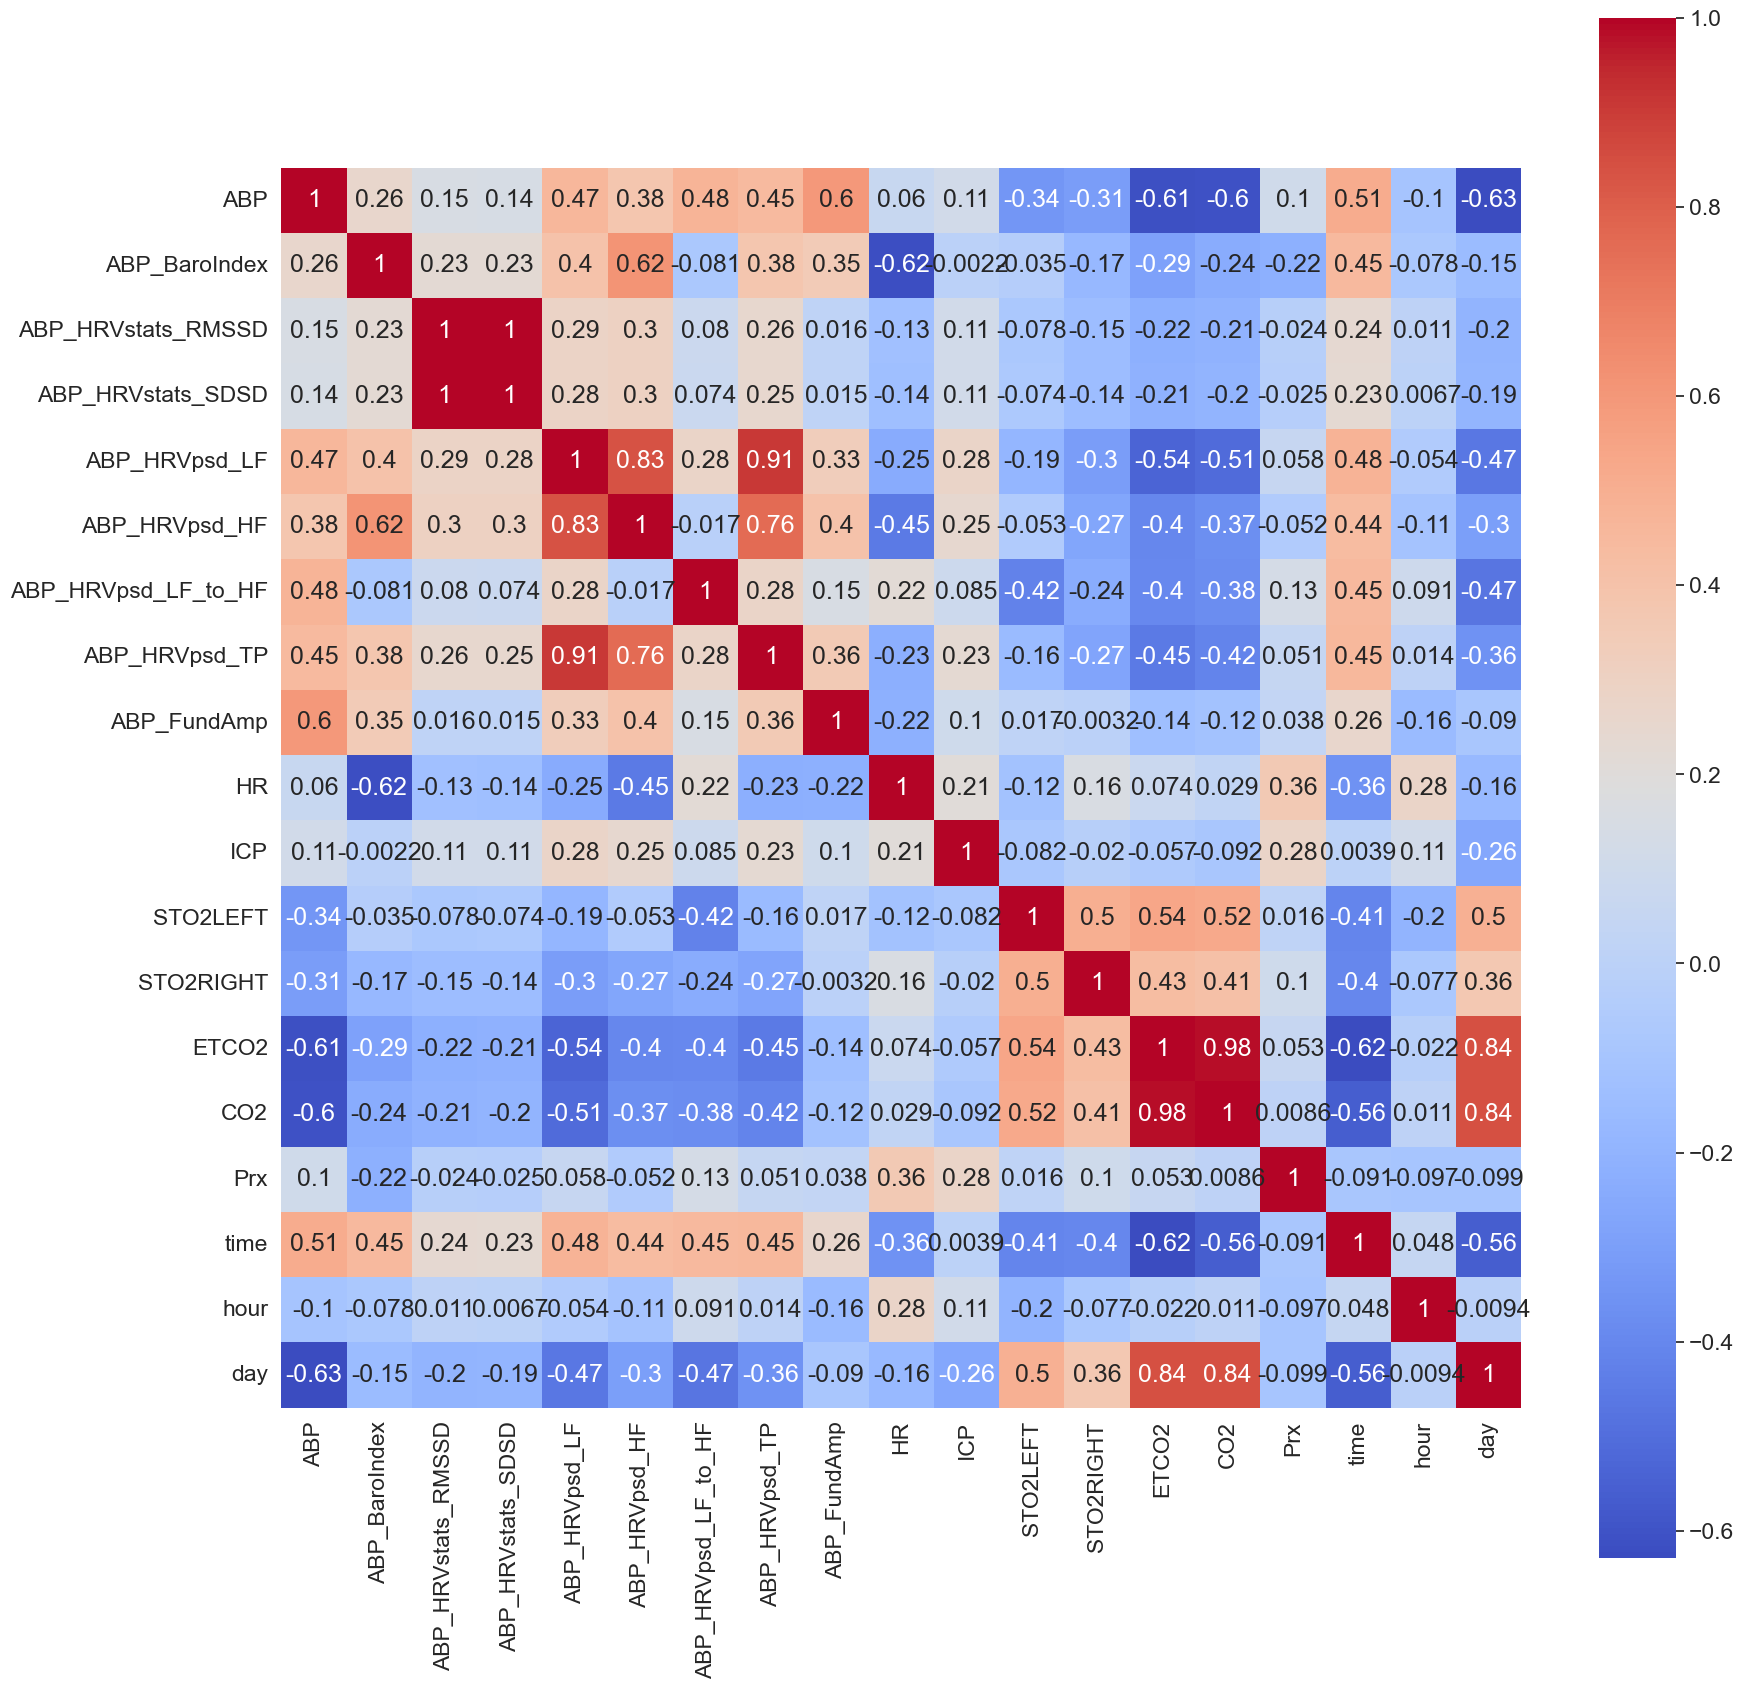

 67%|██████▋   | 2/3 [00:01<00:00,  1.06it/s]

                  index       ABP
0                   ABP  1.000000
1         ABP_BaroIndex  0.216929
2    ABP_HRVstats_RMSSD -0.056500
3     ABP_HRVstats_SDSD -0.056906
4         ABP_HRVpsd_LF  0.229668
5         ABP_HRVpsd_HF  0.131191
6   ABP_HRVpsd_LF_to_HF  0.463436
7         ABP_HRVpsd_TP  0.159985
8           ABP_FundAmp  0.403101
9                    HR -0.219350
10                  ICP  0.279409
11             STO2LEFT -0.011004
12            STO2RIGHT -0.056259
13                ETCO2  0.235456
14                  CO2  0.147627
15                  Prx  0.044933
16                 time -0.342927
17                 hour  0.167602
18                  day -0.360575


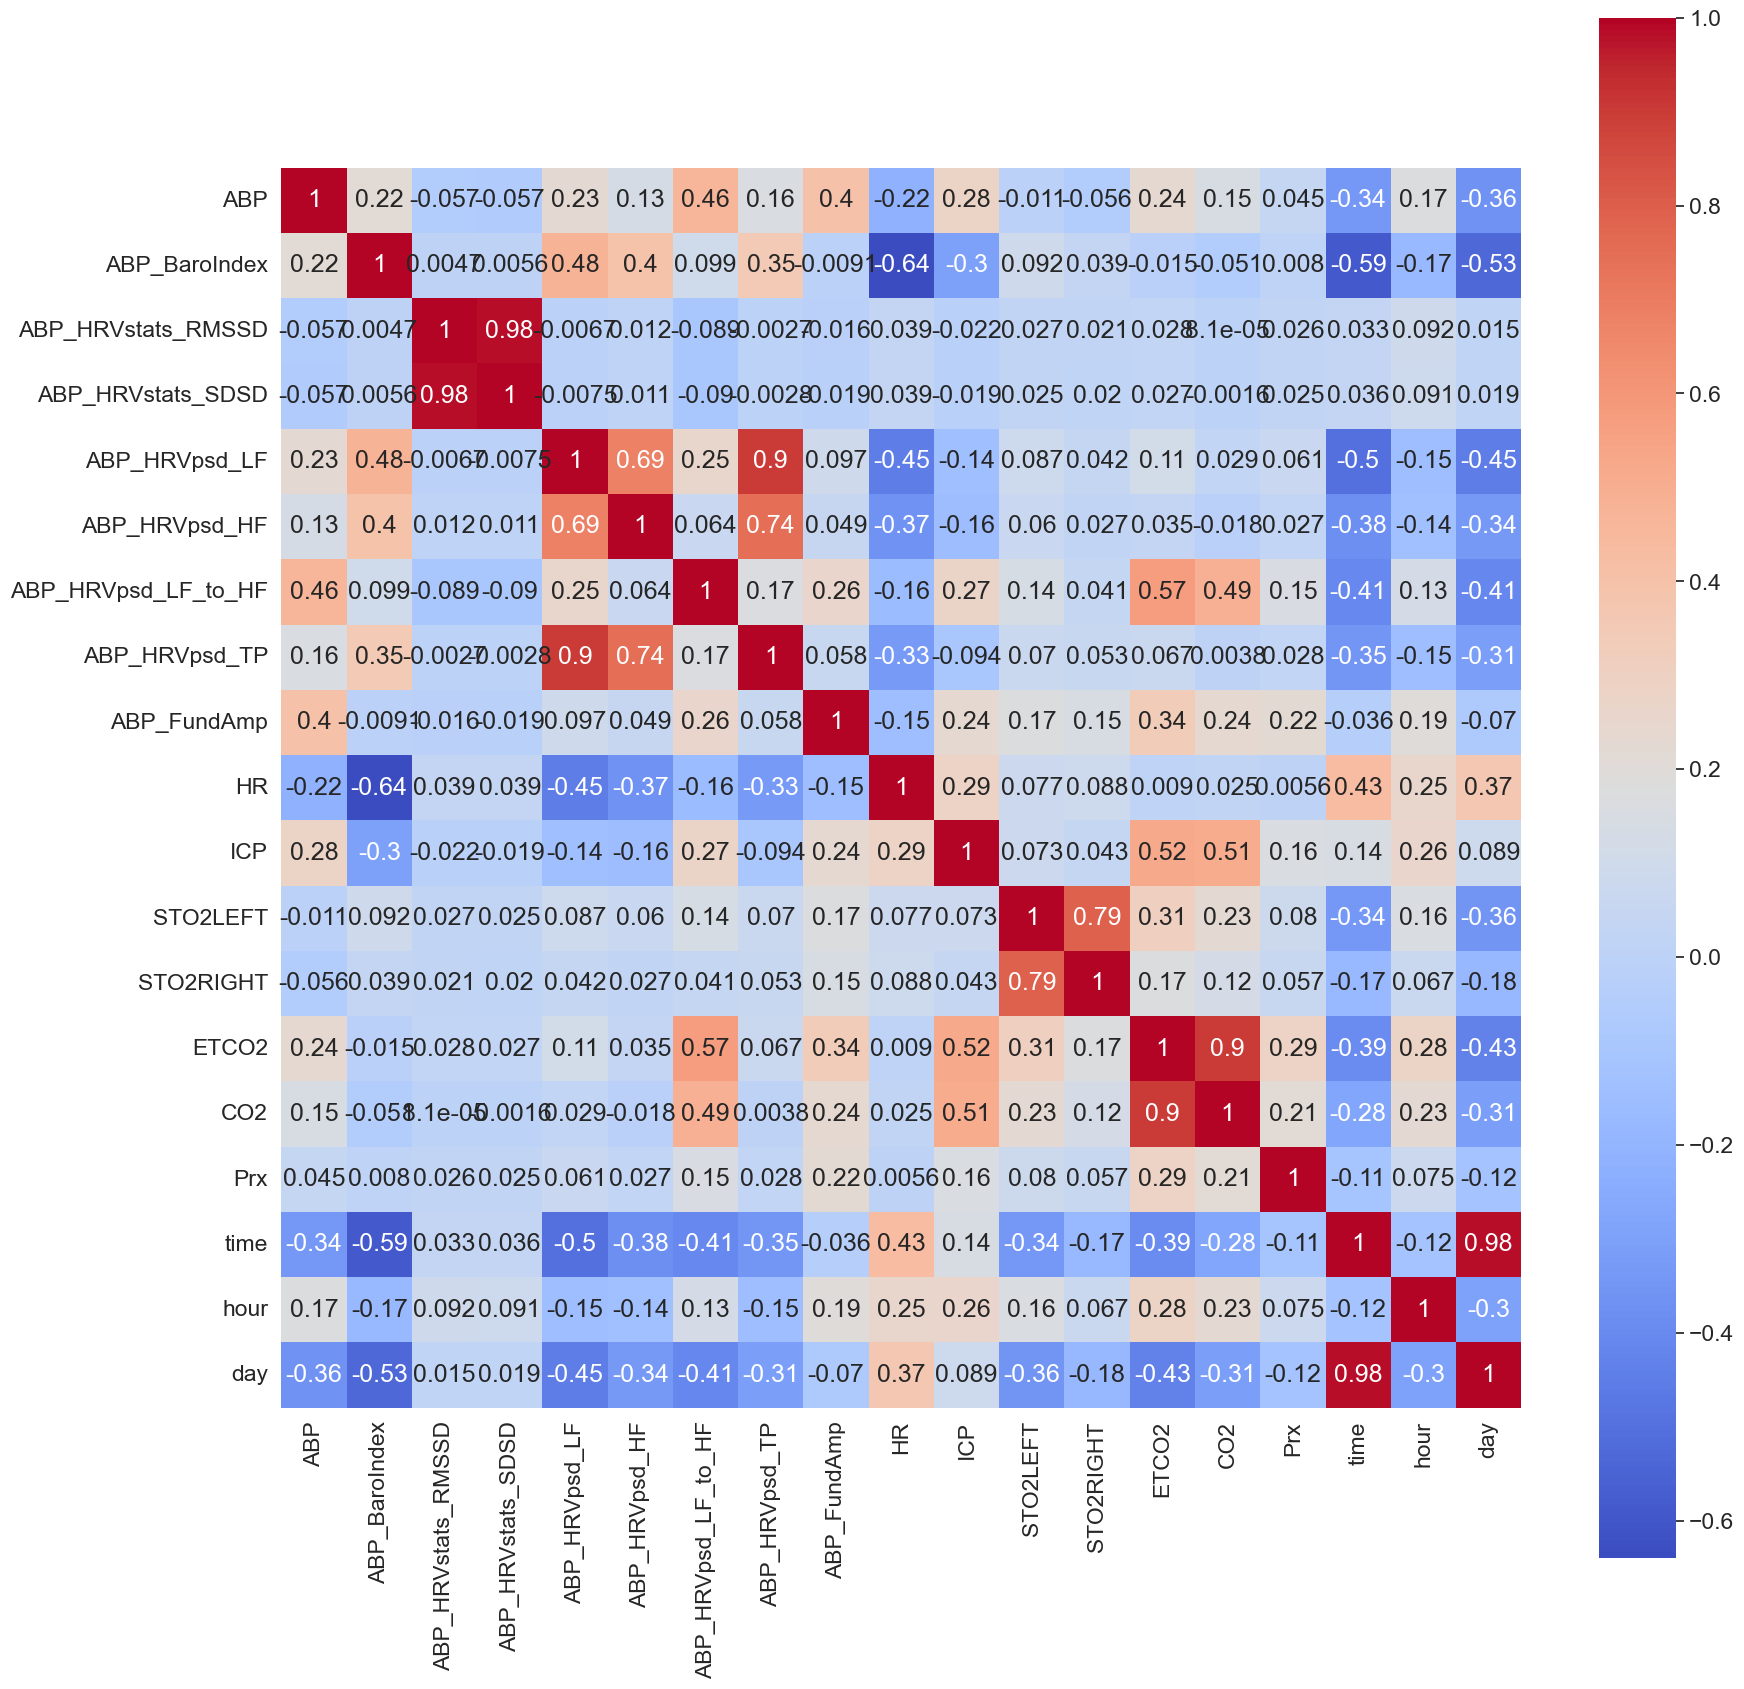

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


In [292]:
corr_values = []
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.dropna()
    plt.figure(figsize=(20, 20)) 
    corr = data_frames[key].corr()
    corr_values.append(corr_melt(corr))
    sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
    plt.show()

### Correlation between patients

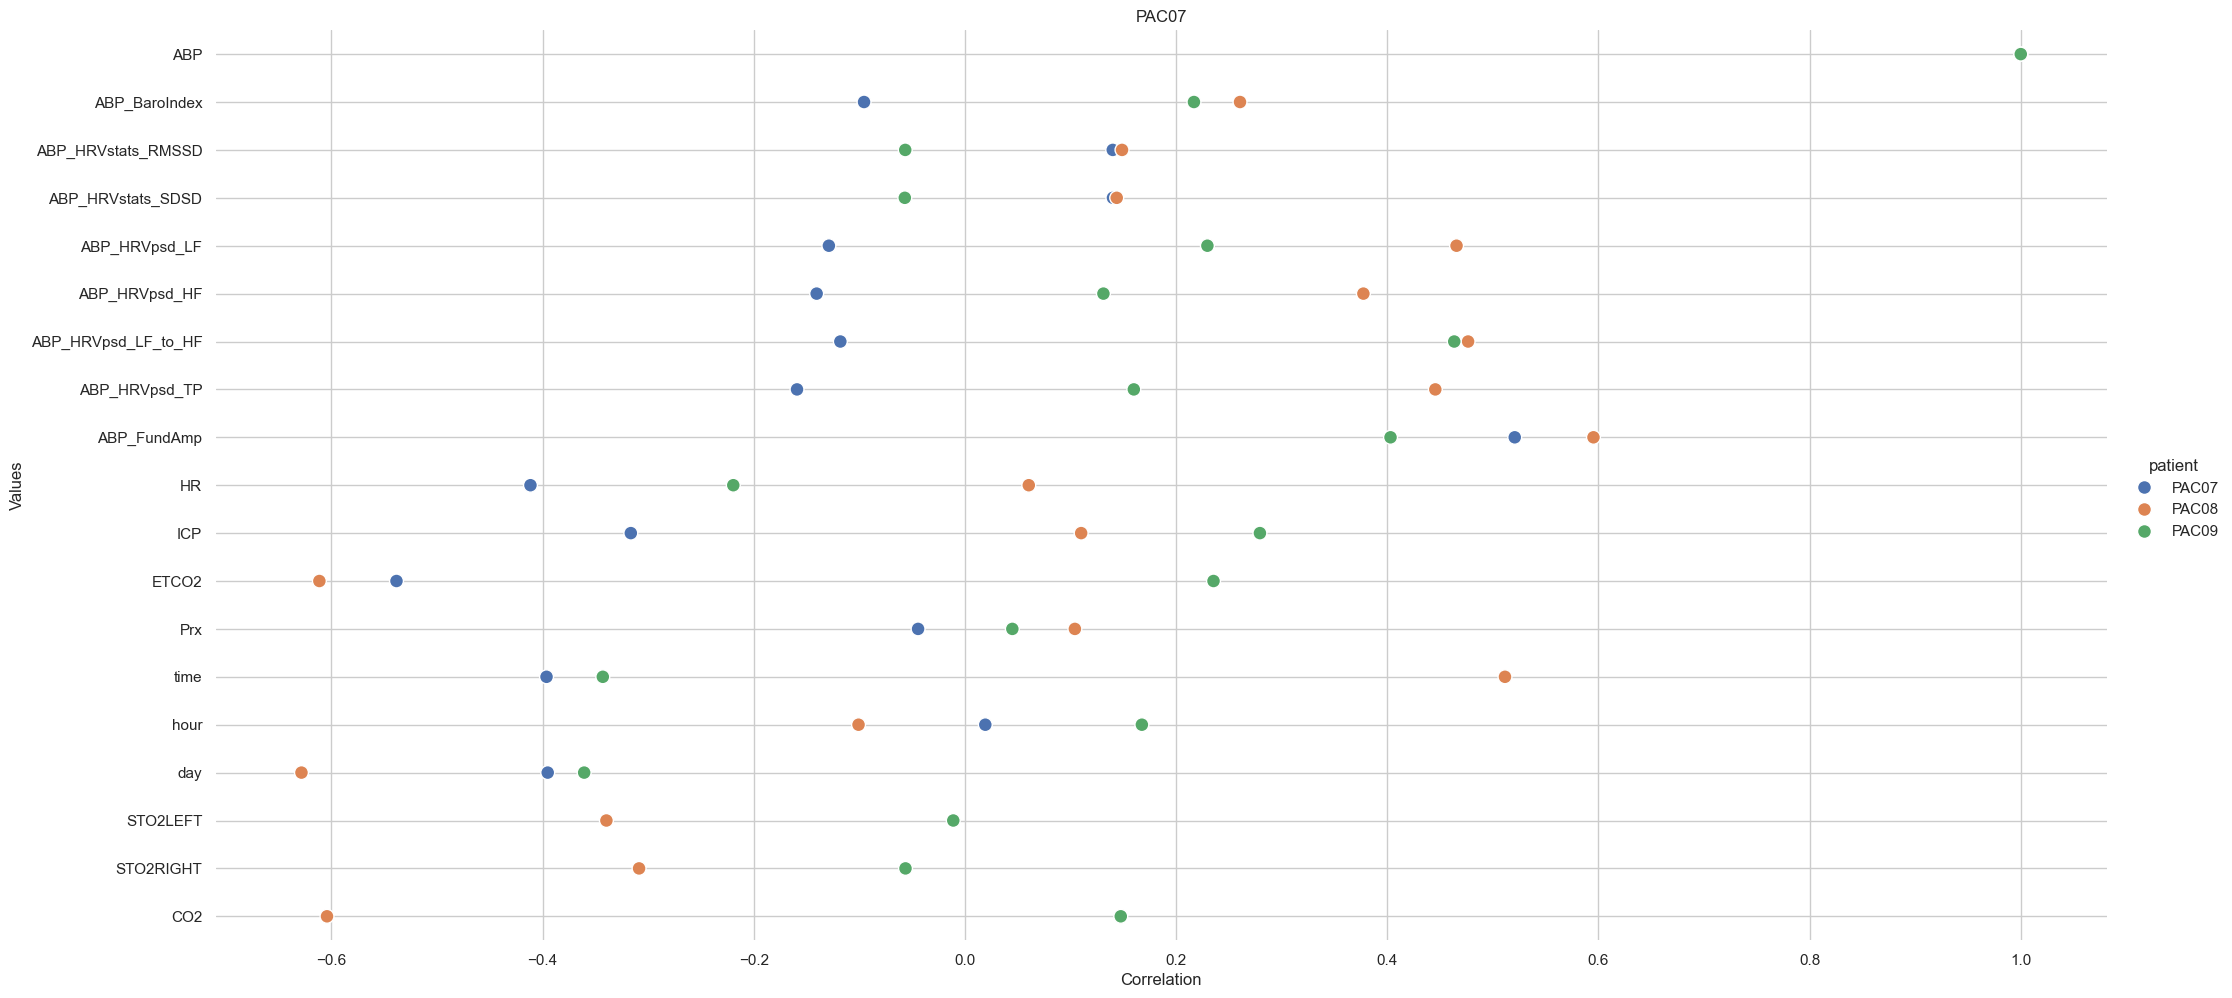

In [348]:
corr_values_df = pd.concat(corr_values)
sns.set_theme(style="whitegrid")
g = sns.PairGrid(corr_values_df, y_vars='value', x_vars='ABP', hue='patient', height=10, aspect=2) 
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")
g.set( xlabel='Correlation', ylabel='Values')
g.add_legend()
for ax, title in zip(g.axes.flat, data_frames.keys()):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)
plt.show()   

Based on this preliminary analysis, we can conclude that `ABP_Fund_Amp` exhibits the strongest correlation with ABP recordings.

### Data Seasonality